In [389]:
''' Import packages and define functions '''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from IPython.display import display
from statsmodels import api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings

# Create function to fit linear regression model and visualize relationships
def show_plots(X, y):
    
    # Fit model, get fitted values, and calculate residual
    lm = LinearRegression()
    X = X.sort_values("date", ascending=True)
    lm.fit(X, y)
    y_hat = lm.predict(X)
    e = y - y_hat
    
    # Plot fitted values against residuals to detect non-constant variance
    plt.scatter(x=e, y=y_hat)
    plt.xlabel("residuals")
    plt.ylabel("fitted values")
    plt.show()
    
    # Plot residuals vs. date to see if there is correlation
    plt.plot(X["date"], e)
    plt.xlabel("date")
    plt.ylabel("residuals")
    plt.show()
    
    # Plot predictors against response to detect non-linear relationships
    for var in X.columns.to_list():
        plt.scatter(x=X[var].values, y=y)
        plt.xlabel(var)
        plt.ylabel("fitted values")
        plt.show()
        
# Create function for logging predictor
def log_predictor(df, var):
    df[var] = df[var].apply(lambda x: max(x, .01))
    df[f"log_{var}"] = np.log(df[var])
    df.drop(columns=[var], inplace=True)

# Fit model and output summary
def fit_model(X, y):
    X_cnst = sm.add_constant(X)
    lm = sm.OLS(y, X_cnst).fit()
    print(lm.summary())

# Calculate VIF
def calculate_vif(df, threshold):
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif = vif.sort_values(by=["VIF"], ascending=False)
    high_vif_df = vif[vif["VIF"] > threshold]
    display(high_vif_df)
    
# Create interactions
def create_interactions(df, var1, var2):
    df[f"{var1}:{var2}"] = df[var1] * df[var2]

# Function for eliminating influential outliers
def elim_infl_outliers(data_label, X, y):
    # Fit model
    X_cnst = sm.add_constant(X)
    lm = sm.OLS(y, X).fit()
    
    # Get influence measures
    influence = lm.get_influence()
    
    # Obtain summary df of influence measures
    inf_df = influence.summary_frame()
    
    # Get leverage statistic
    leverage = influence.hat_matrix_diag
    
    # Plot leverage vs. studentized residuals
    sn.regplot(leverage, lm.resid_pearson, fit_reg=False)
    plt.title(f"Leverage vs. Studentized Residuals - {data_label} Dataset")
    plt.xlabel("Leverage")
    plt.ylabel("Studentized Residuals")
    
    # Set leverage threshold to (2k + 2)/n, where n is the number of observations and k is the number of features
    n = inf_df.shape[0]
    k = inf_df.shape[1]
    leverage_threshold = (2*k + 2)/n 
    
    # Calculate absolute value of studentized residuals
    inf_df["abs_student_resid"] = inf_df["student_resid"].apply(lambda x: abs(x))
    
    # Get indexes of influential outliers
    influential_idx = inf_df[(inf_df["abs_student_resid"] > 3)
                         & (inf_df["hat_diag"]) > leverage_threshold].index.tolist()
    
    print(f"The number of influential observations in the {data_label} dataset is {len(influential_idx)}.")
    
    # Drop observations from X and y that are influential outliers
    X.drop(influential_idx, inplace=True)
    y.drop(influential_idx, inplace=True)

In [390]:
''' Read in and examine data '''

# Set option to display all df columns
pd.set_option('display.max_columns', None)

# Suppress warnings
warnings.filterwarnings("ignore")

# Replace path with your own directory to re-run
my_path = "/Users/thomasfleming/Desktop/machine_learning"

# Read in mock dataset
df = pd.read_csv(f"{my_path}/home_data.csv")

# View head of dataset, non-null count, and dtypes
display(df.head())
display(df.info())

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  int64  
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

None

In [391]:
''' Initial re-formatting and dropping of variables, based on logic '''

# Get year, month, and day from date field, then convert to datetime and then ordinal
df["date"] = pd.to_datetime(df["date"].str[:8]).map(dt.datetime.toordinal)

# Create basement indicator variable
df["basement"] = df["sqft_basement"].apply(lambda x: 1 if x > 0 else 0)

# Create yr_renovated indicator variable
df["renovated"] = df["yr_renovated"].apply(lambda x: 1 if x > 0 else 0)

# Create dummy variables for zipcodes and drop zipcode, lat, and long fields
zip_dummies = pd.get_dummies(df["zipcode"], prefix="zip")
zip_list = zip_dummies.columns.tolist()
for col in zip_list:
    df[col] = zip_dummies[col]

# Drop unneeded variables
df.drop(columns=["zipcode", "lat", "long"], inplace=True)

# View head of dataset, non-null count, and dtypes
display(df.head())
display(df.info())

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,basement,renovated,zip_98001,zip_98002,zip_98003,zip_98004,zip_98005,zip_98006,zip_98007,zip_98008,zip_98010,zip_98011,zip_98014,zip_98019,zip_98022,zip_98023,zip_98024,zip_98027,zip_98028,zip_98029,zip_98030,zip_98031,zip_98032,zip_98033,zip_98034,zip_98038,zip_98039,zip_98040,zip_98042,zip_98045,zip_98052,zip_98053,zip_98055,zip_98056,zip_98058,zip_98059,zip_98065,zip_98070,zip_98072,zip_98074,zip_98075,zip_98077,zip_98092,zip_98102,zip_98103,zip_98105,zip_98106,zip_98107,zip_98108,zip_98109,zip_98112,zip_98115,zip_98116,zip_98117,zip_98118,zip_98119,zip_98122,zip_98125,zip_98126,zip_98133,zip_98136,zip_98144,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199
0,7129300520,735519,221900,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,1340,5650,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,6414100192,735576,538000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,1690,7639,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5631500400,735654,180000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,2720,8062,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2487200875,735576,604000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,1360,5000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,1954400510,735647,510000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,1800,7503,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 90 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  int64  
 2   price          21613 non-null  int64  
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  sqft_living15  21613 non-null  int64  
 17  sqft_lot15     21613 non-null  int64  
 18  baseme

None

18377    323000
15184    340000
18871    280000
20142    550000
4113     462600
Name: price, dtype: int64

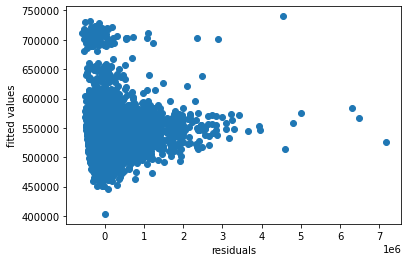

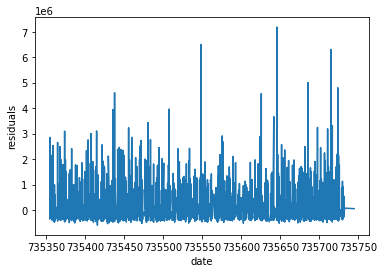

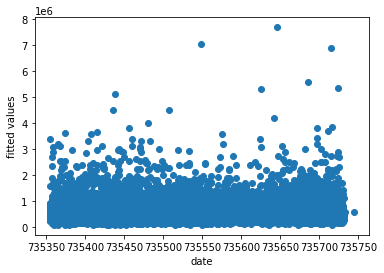

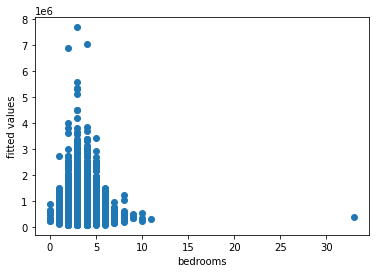

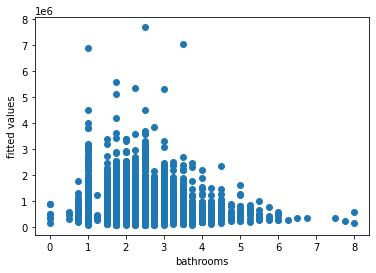

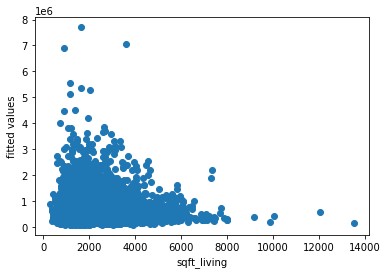

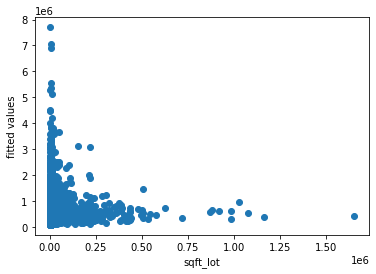

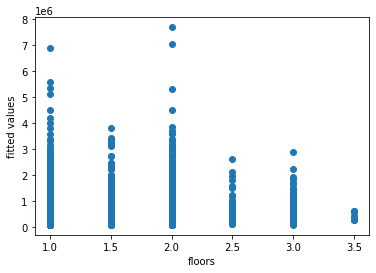

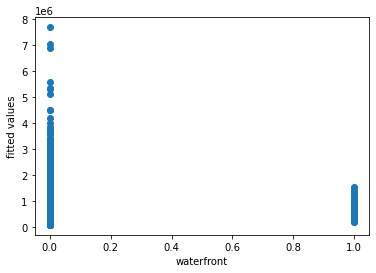

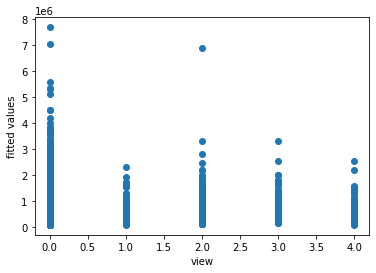

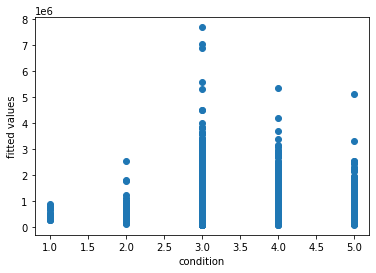

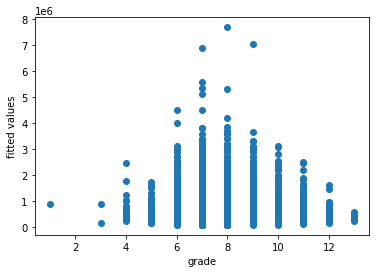

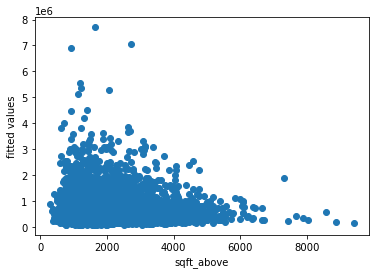

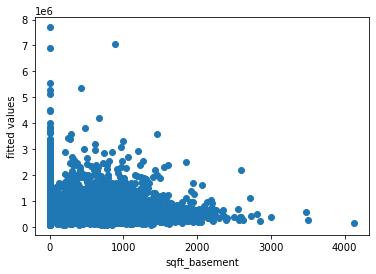

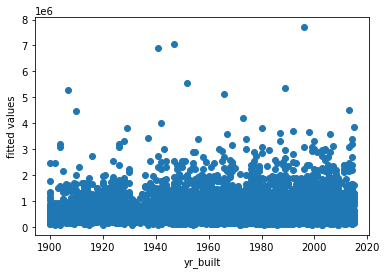

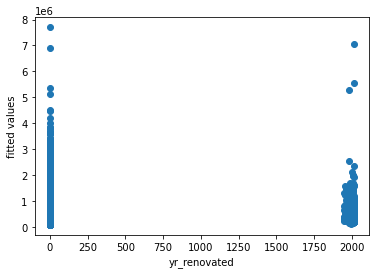

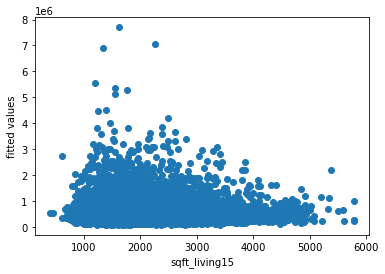

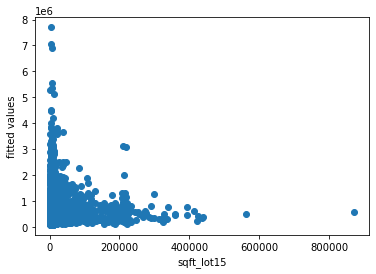

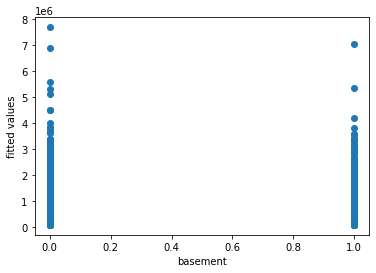

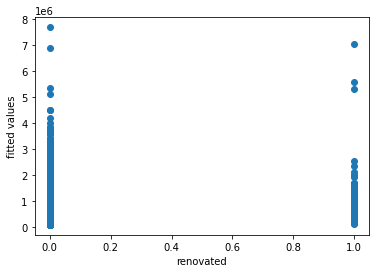

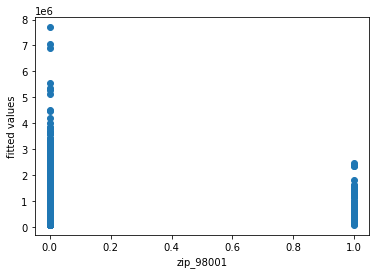

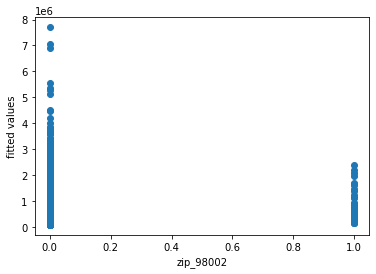

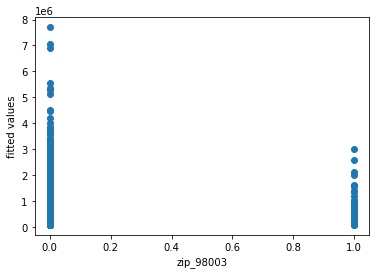

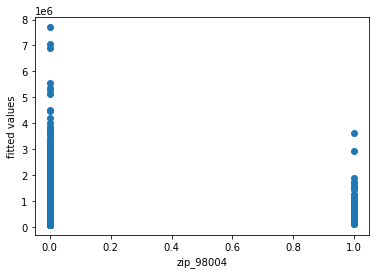

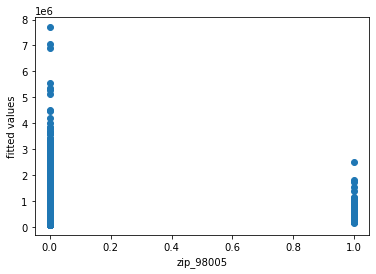

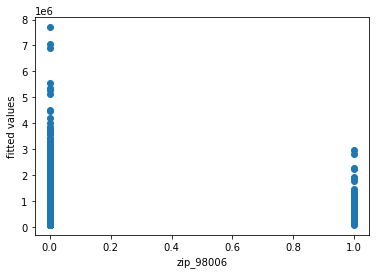

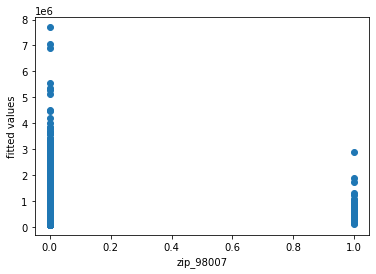

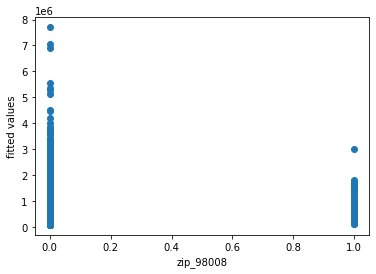

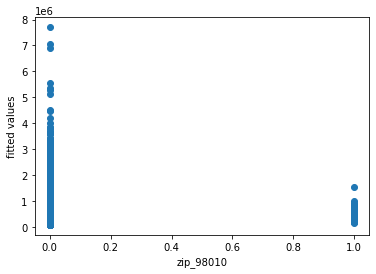

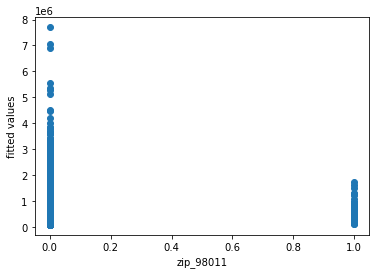

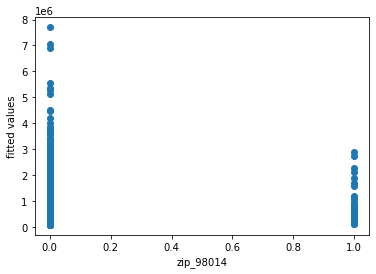

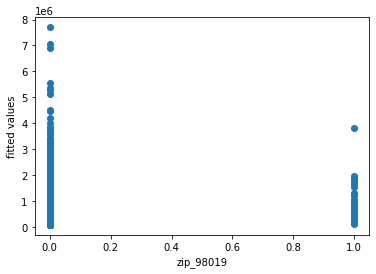

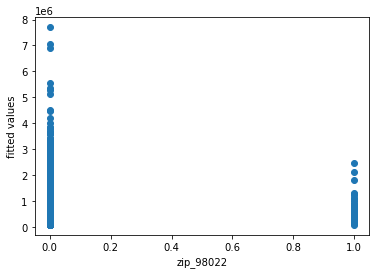

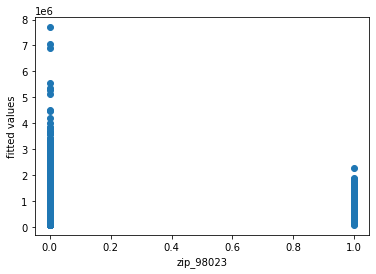

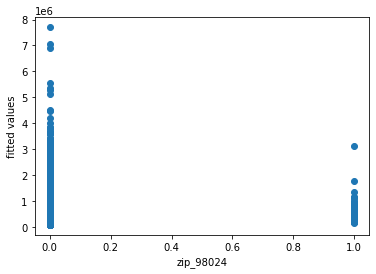

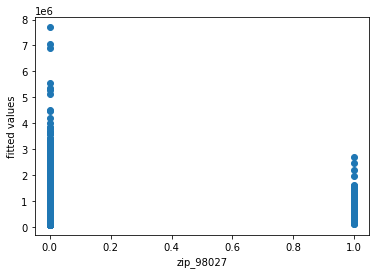

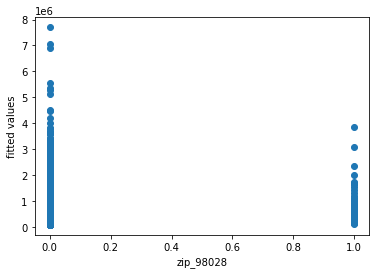

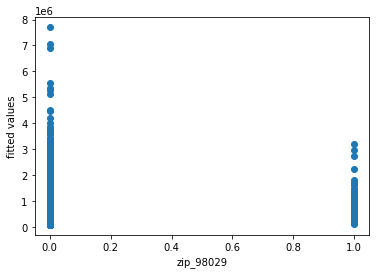

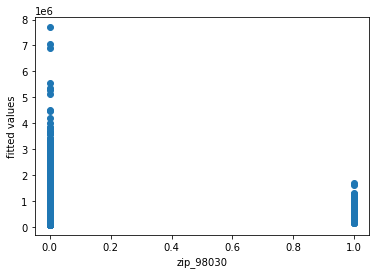

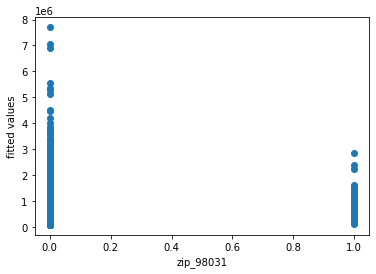

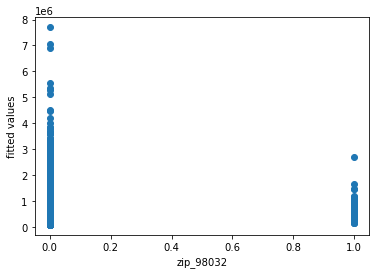

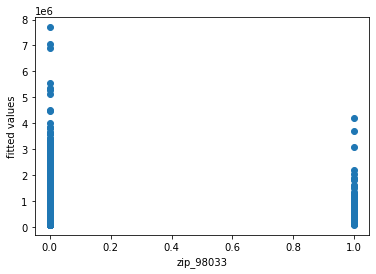

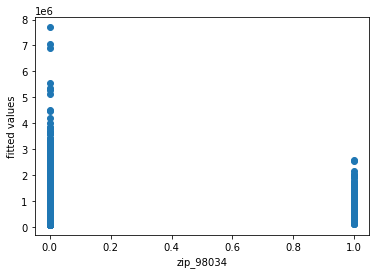

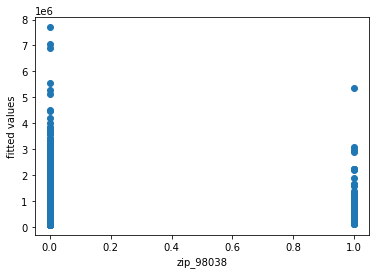

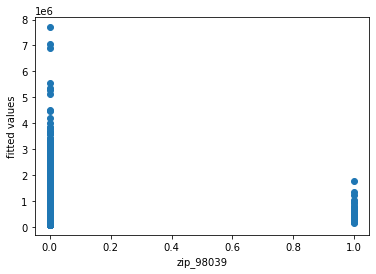

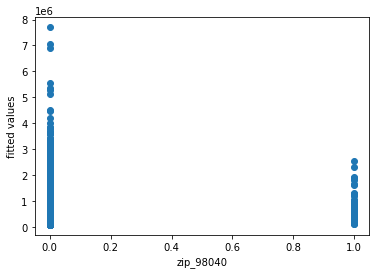

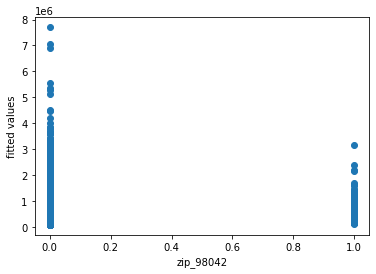

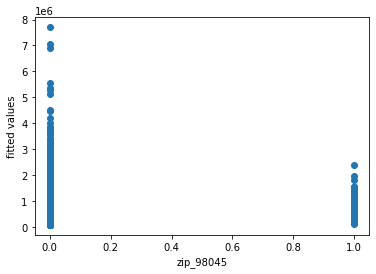

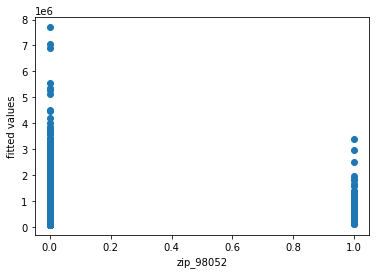

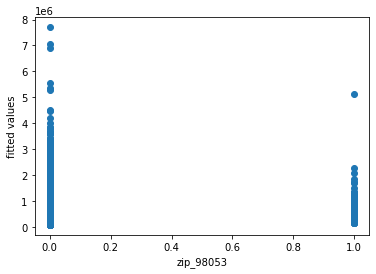

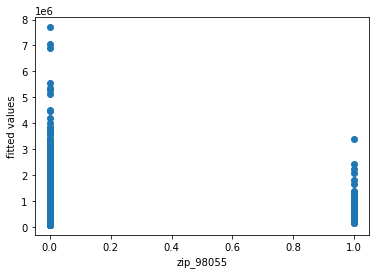

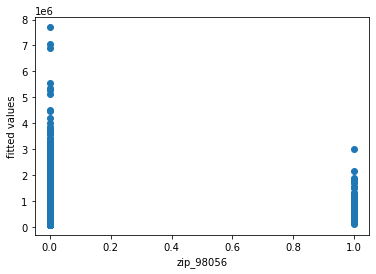

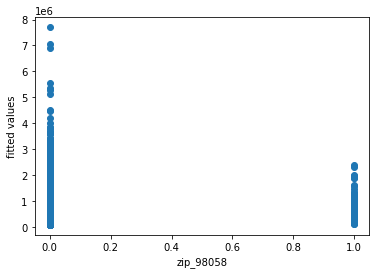

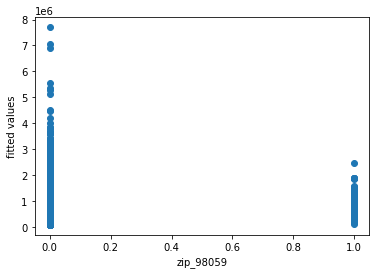

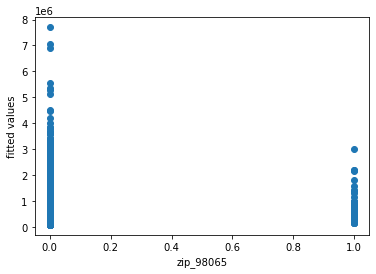

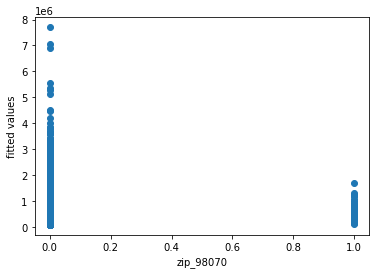

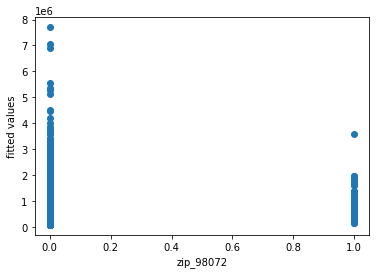

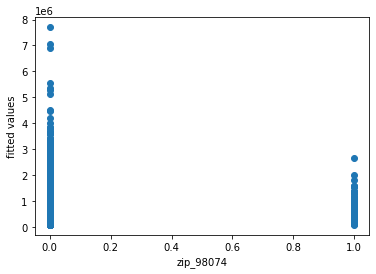

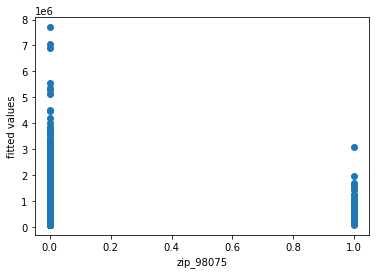

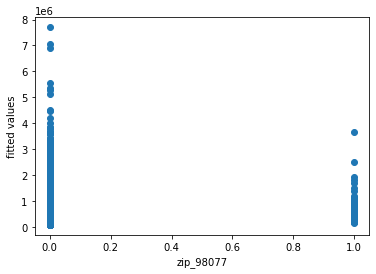

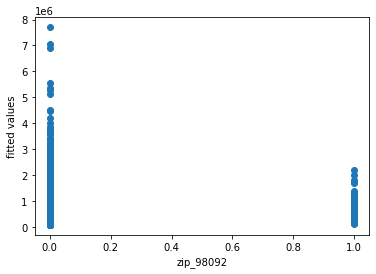

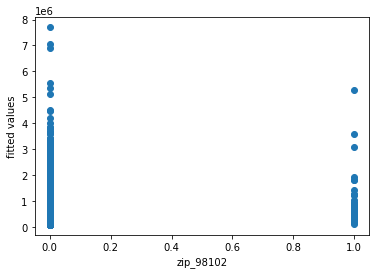

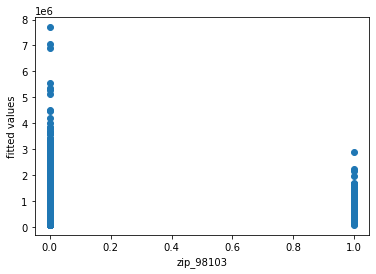

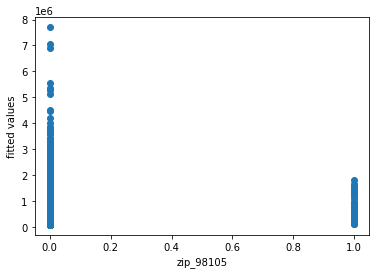

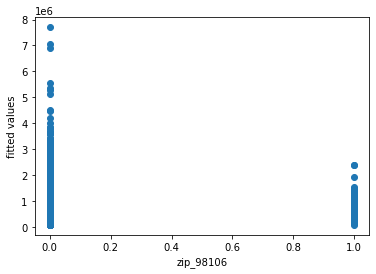

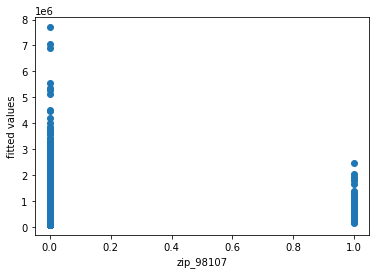

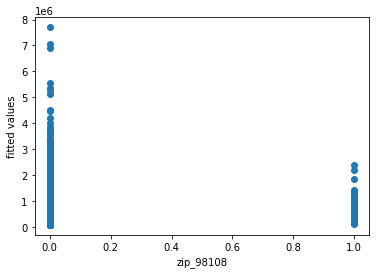

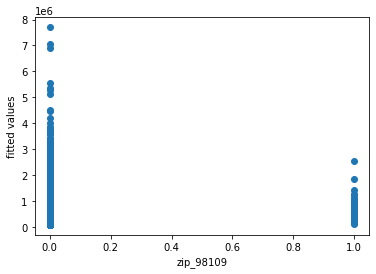

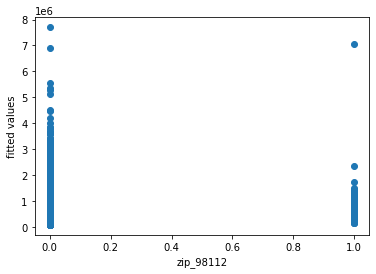

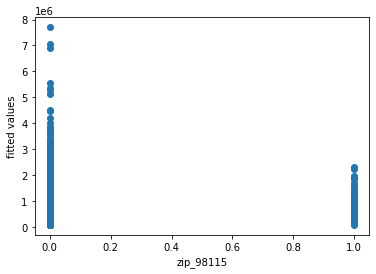

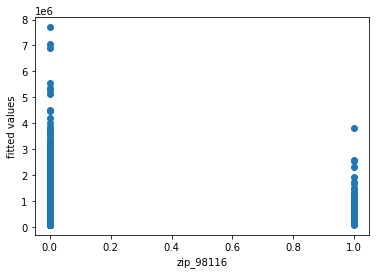

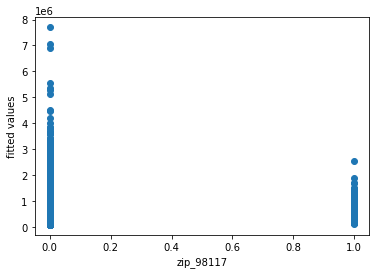

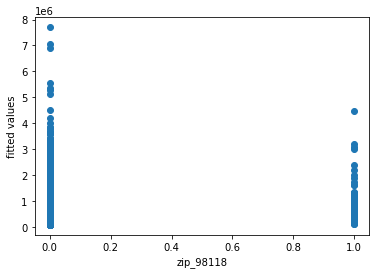

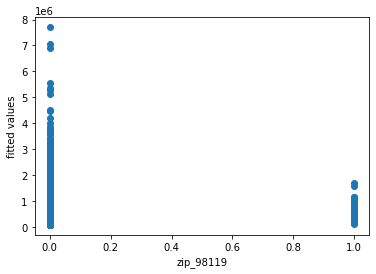

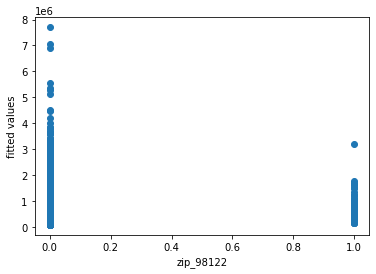

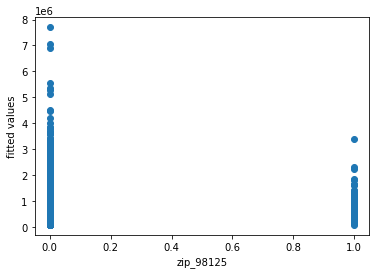

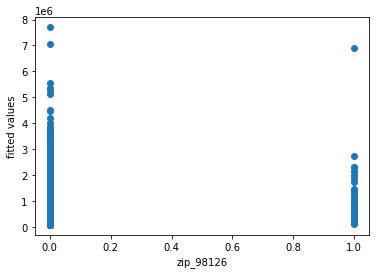

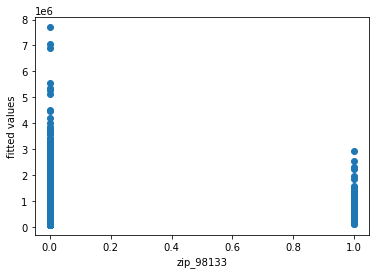

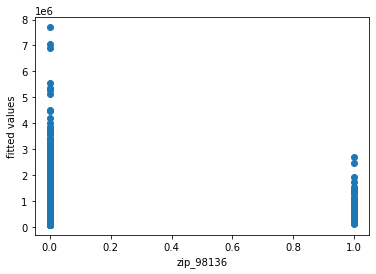

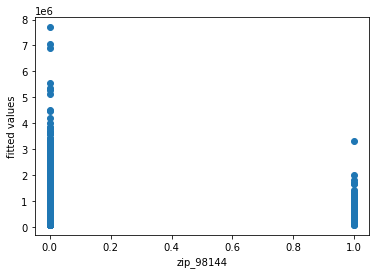

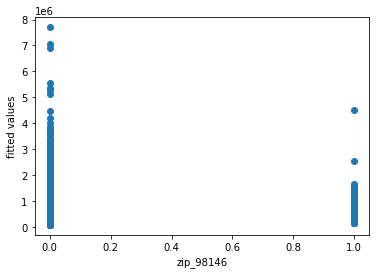

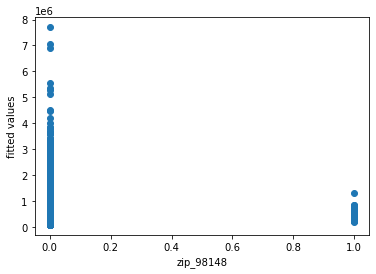

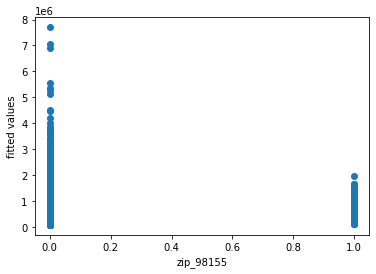

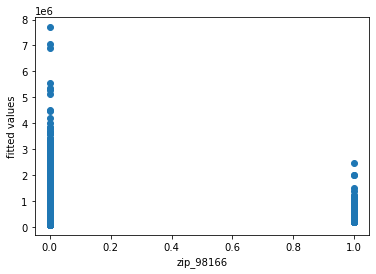

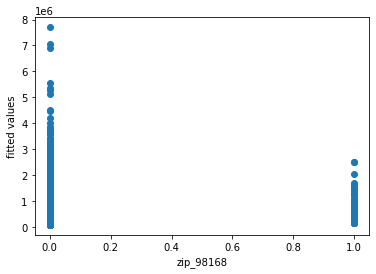

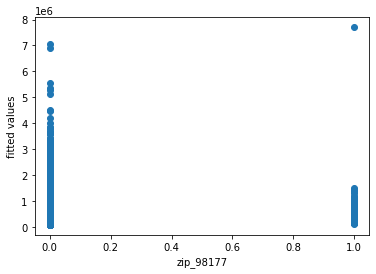

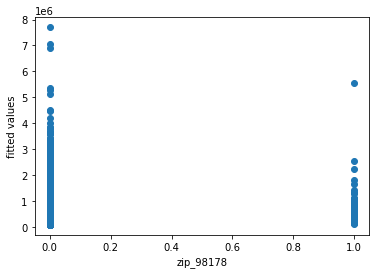

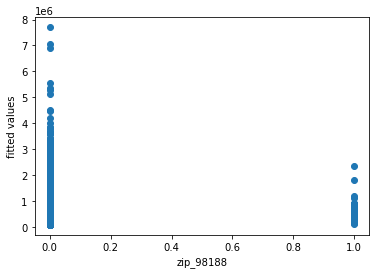

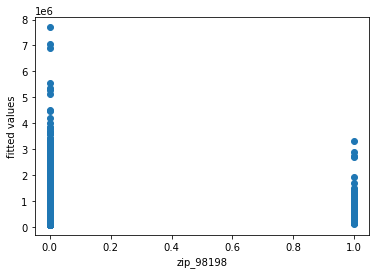

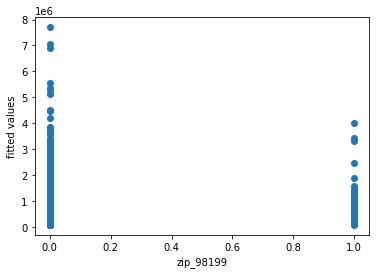

In [392]:
''' Take an initial look at the residual and predictor relationships with the fitted values '''

# Set y to price
y = df["price"]

# Set design matrix to include all fields except select ones
X = df.loc[:, ~df.columns.isin(["id", "price"])]

# Split data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)

# Fit initial model and see relationships
show_plots(X_train, y_train)

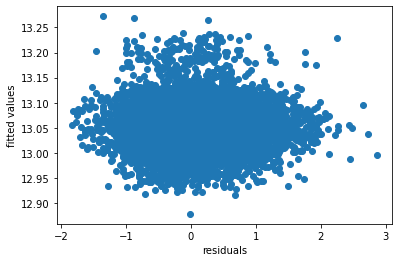

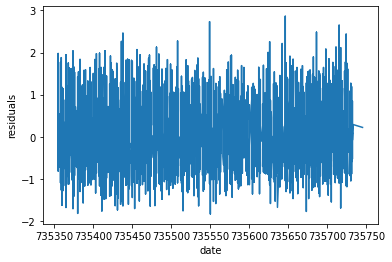

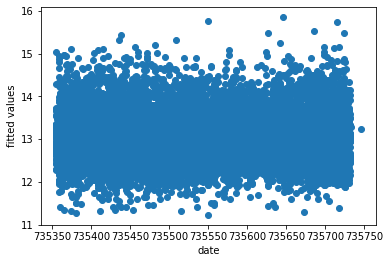

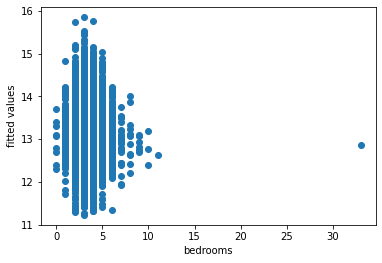

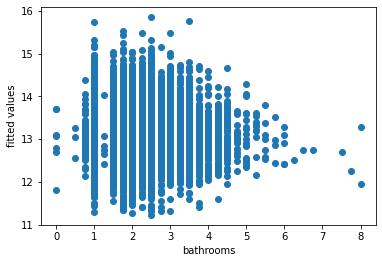

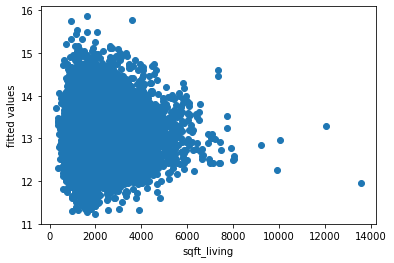

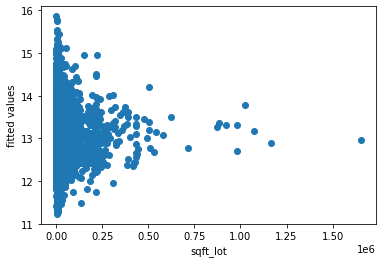

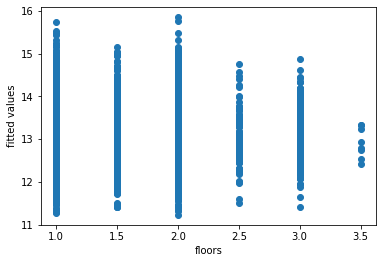

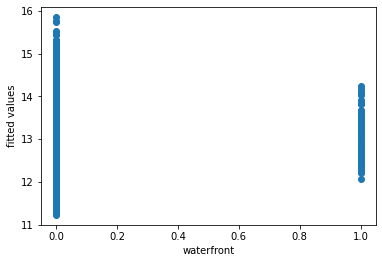

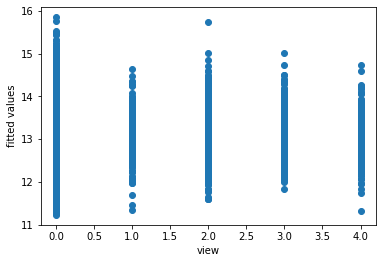

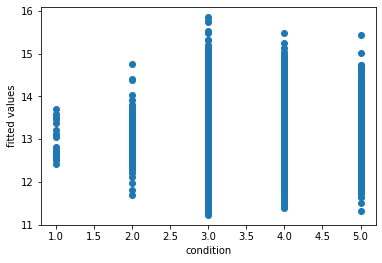

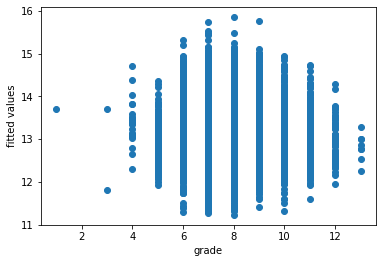

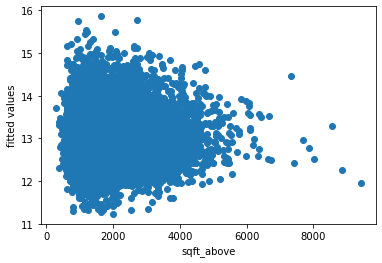

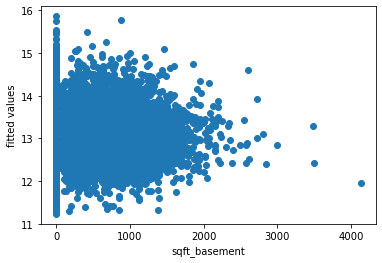

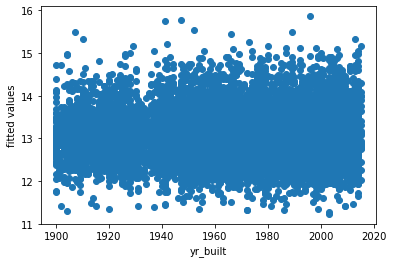

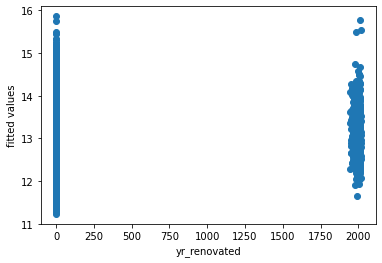

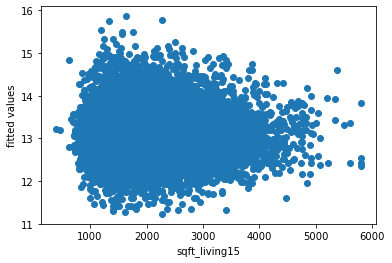

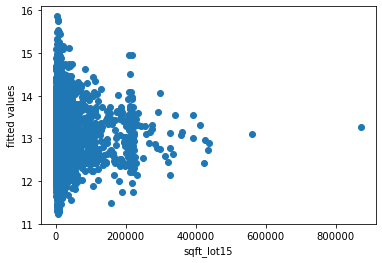

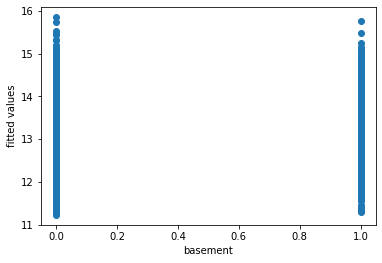

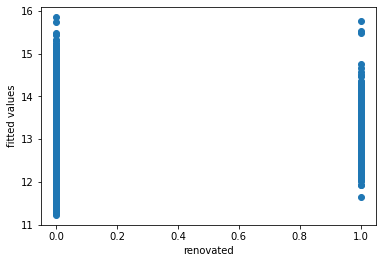

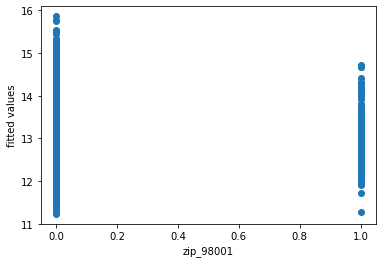

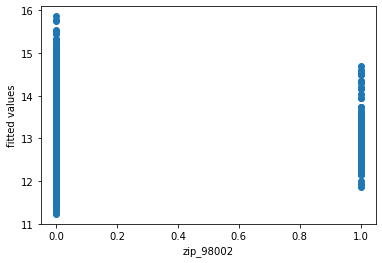

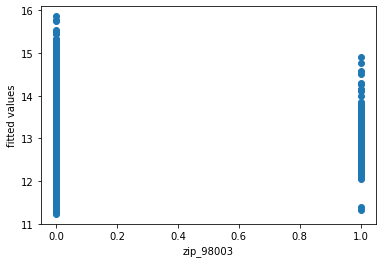

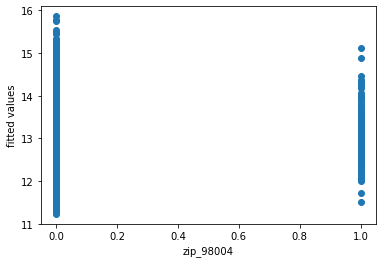

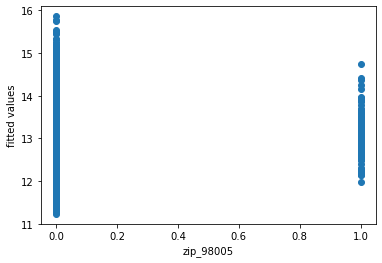

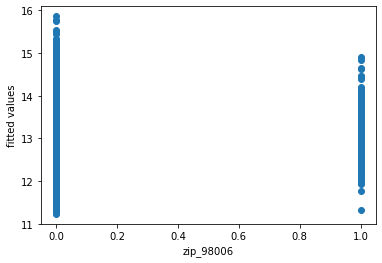

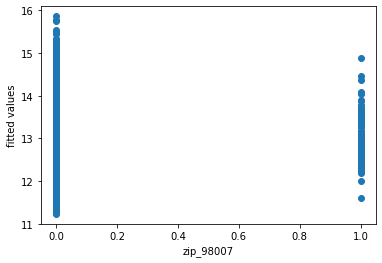

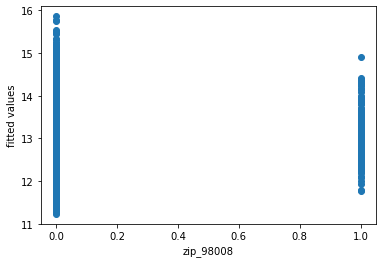

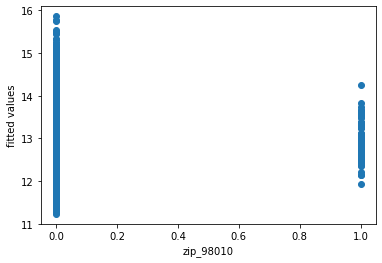

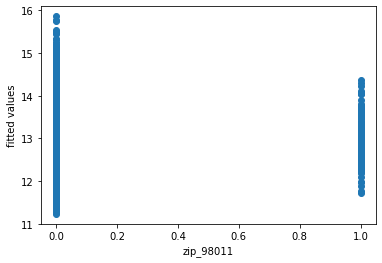

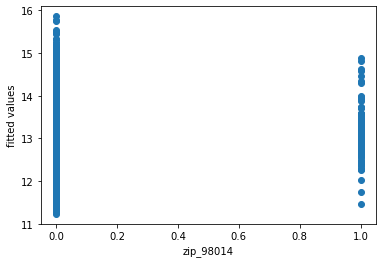

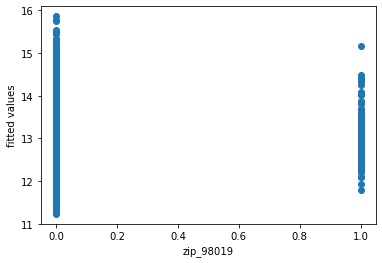

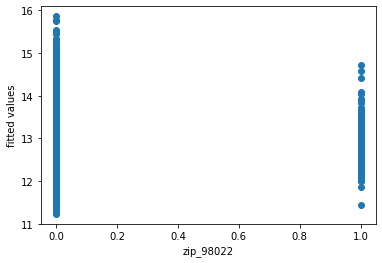

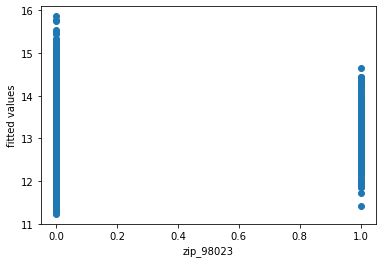

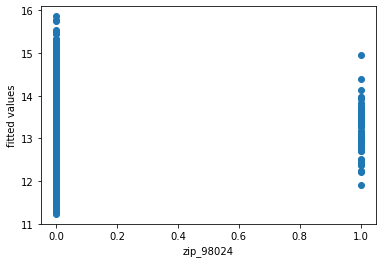

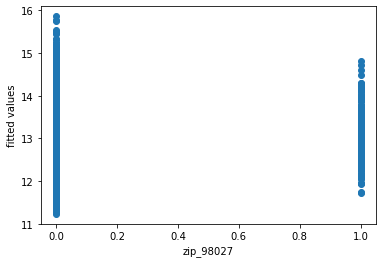

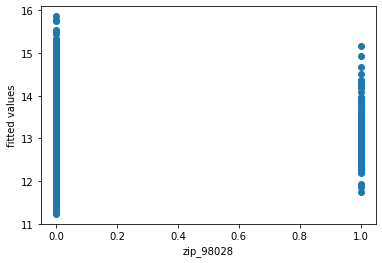

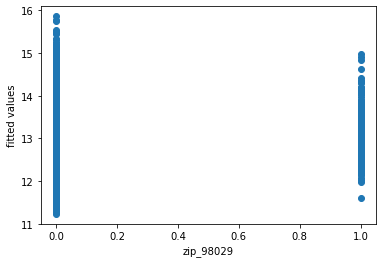

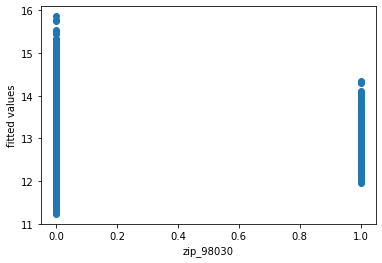

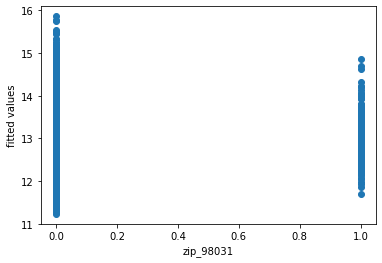

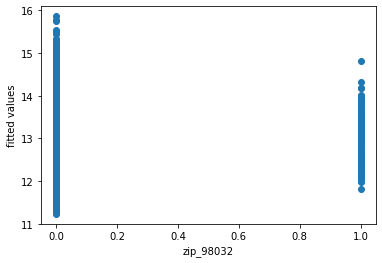

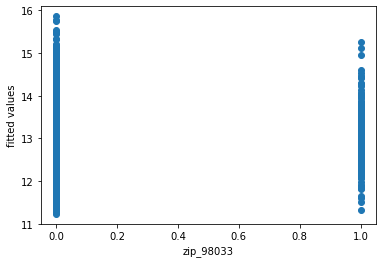

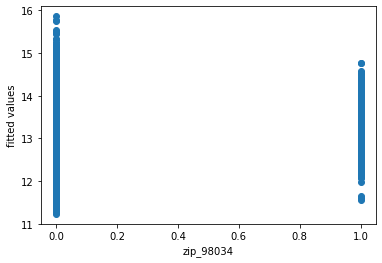

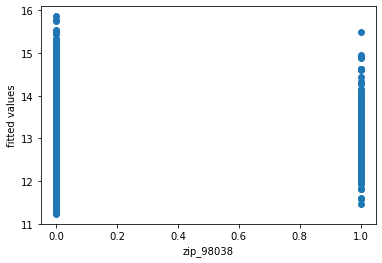

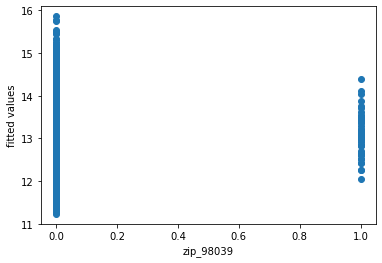

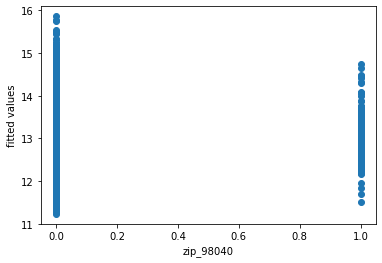

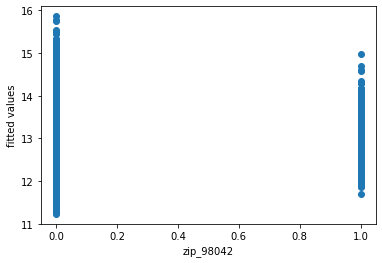

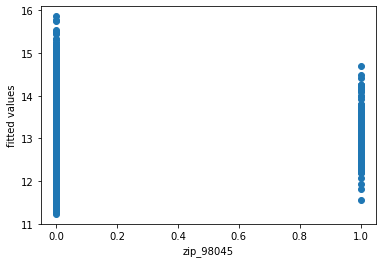

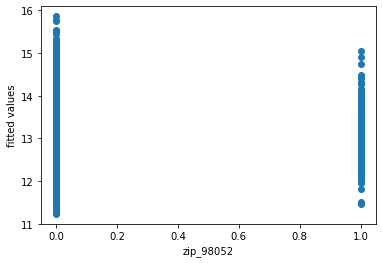

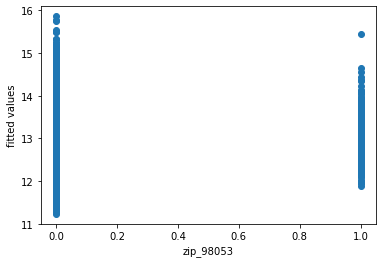

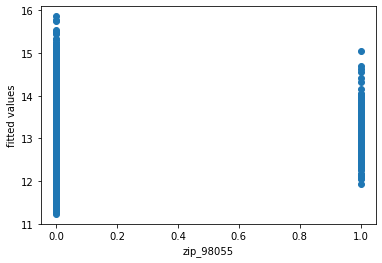

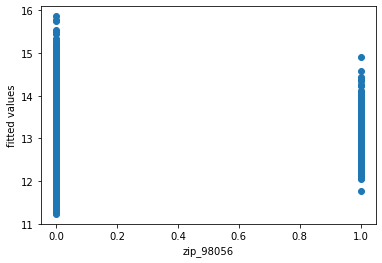

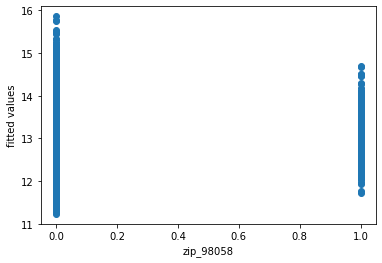

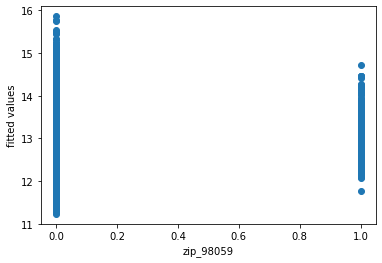

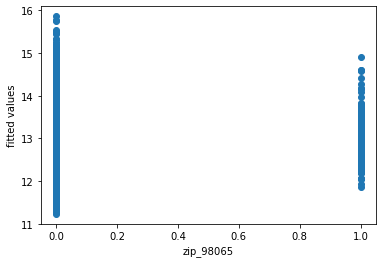

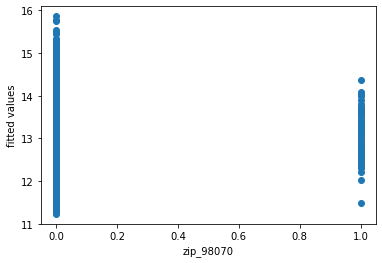

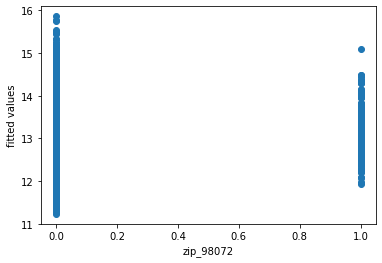

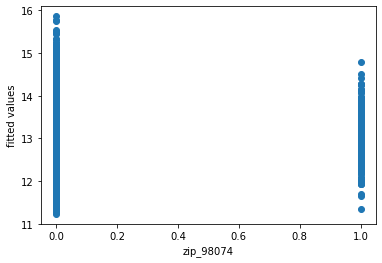

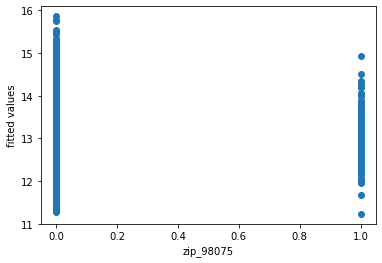

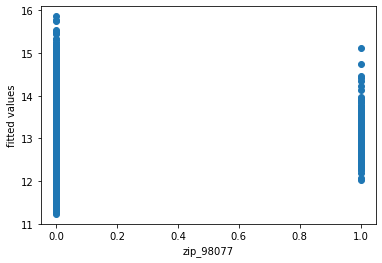

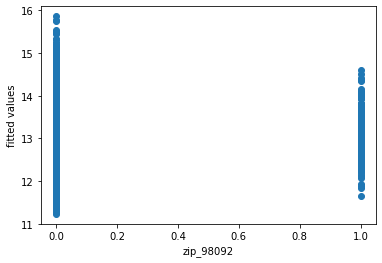

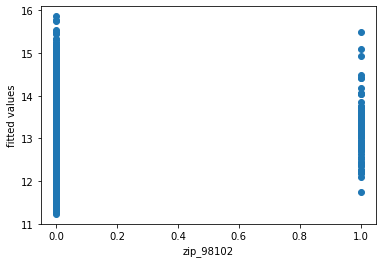

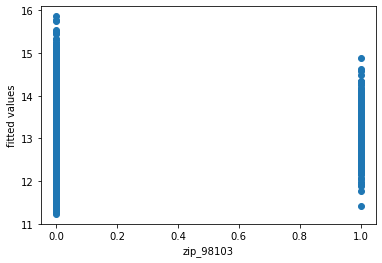

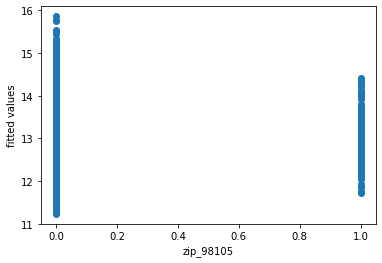

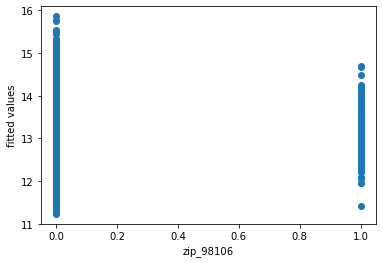

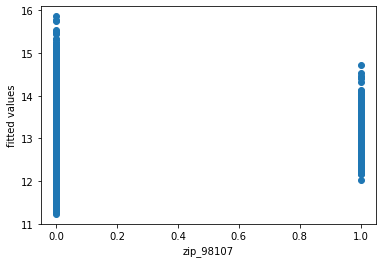

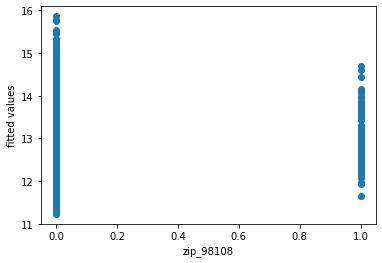

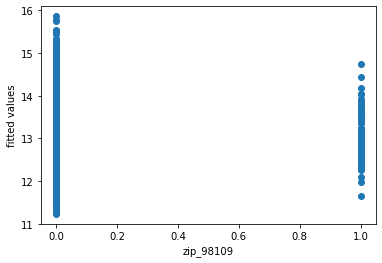

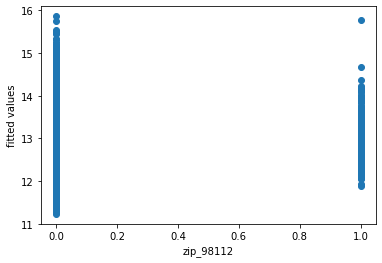

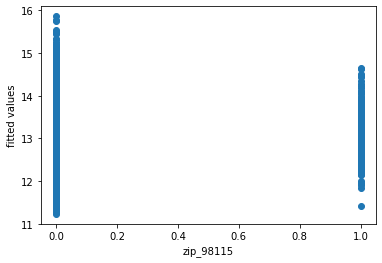

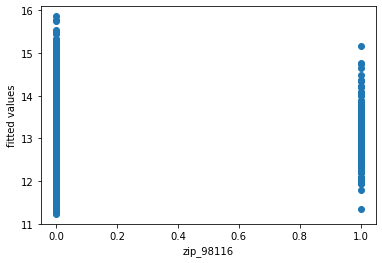

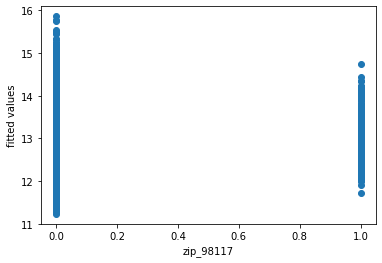

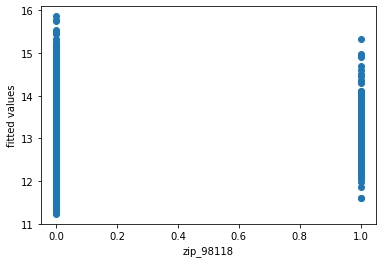

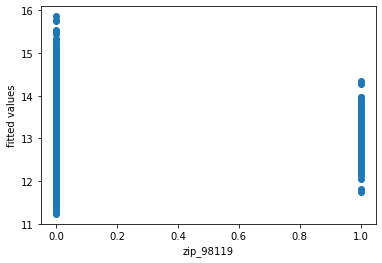

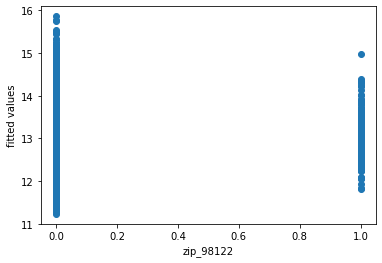

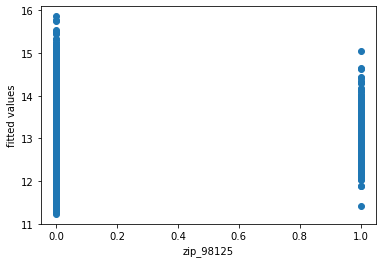

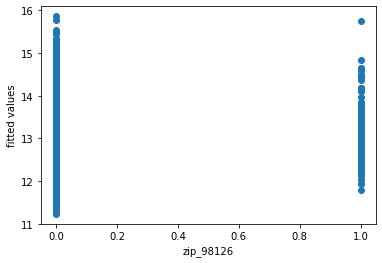

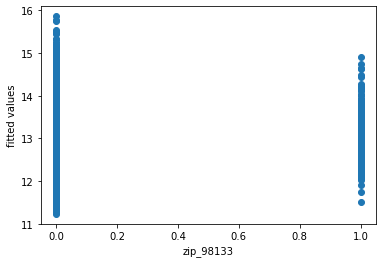

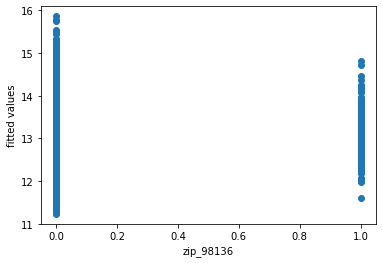

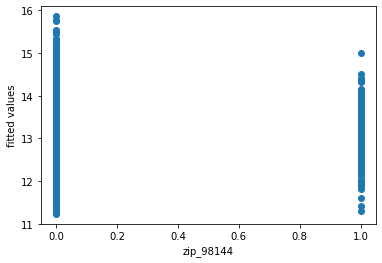

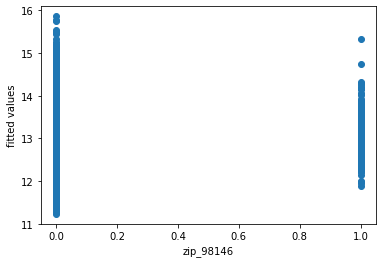

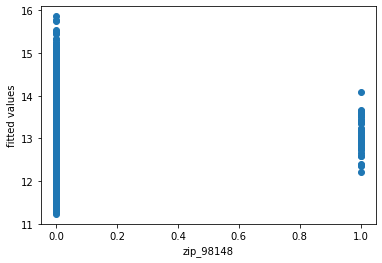

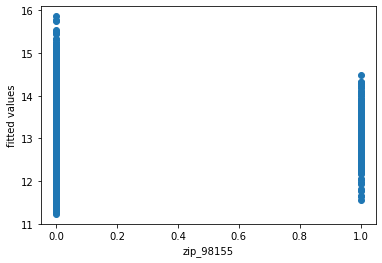

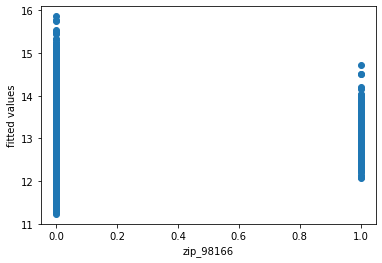

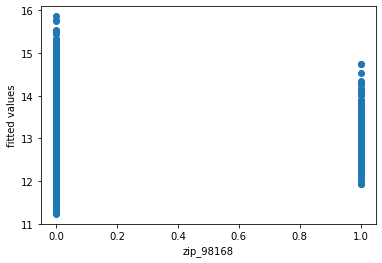

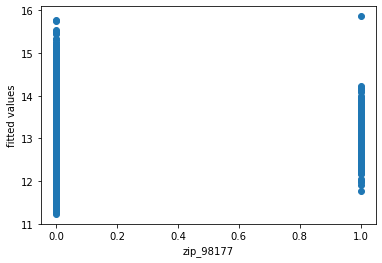

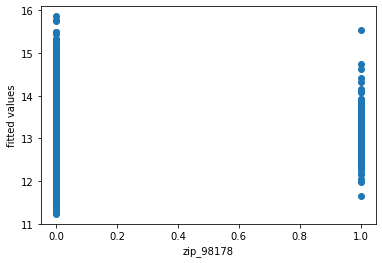

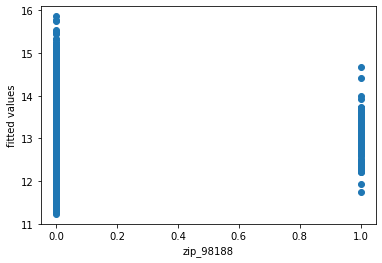

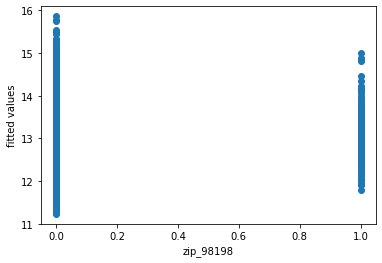

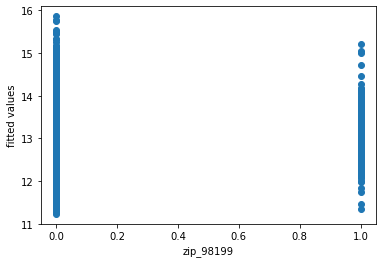

In [393]:
''' Log the response to control the heteroskedasticity '''

# Log price
y_train = np.log(df.iloc[y_train.index.tolist()]["price"])
y_test = np.log(df.iloc[y_test.index.tolist()]["price"])

# Fit model again with logged response
show_plots(X_train, y_train)

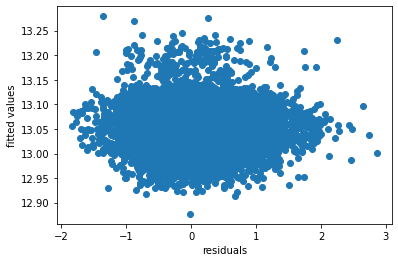

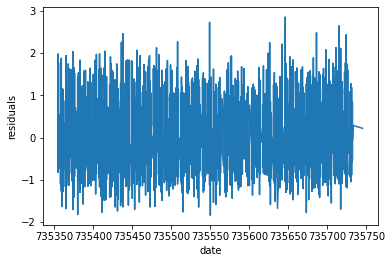

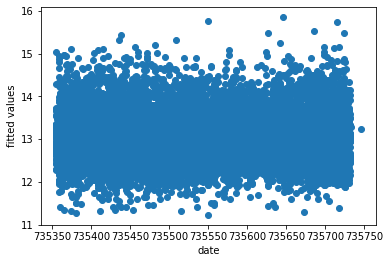

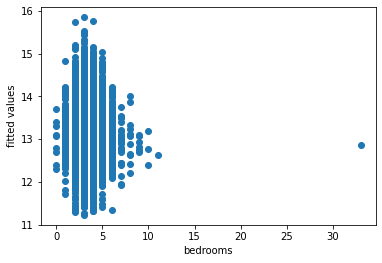

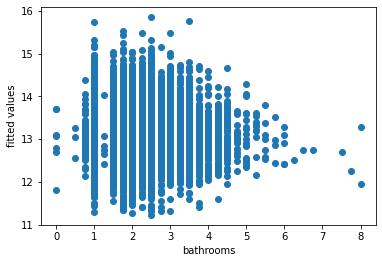

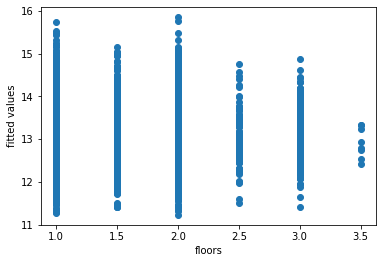

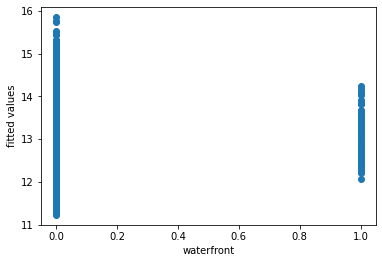

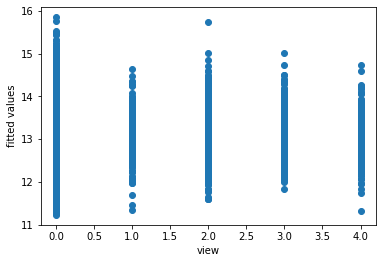

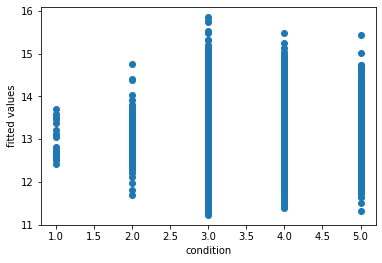

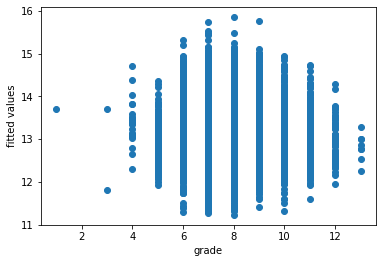

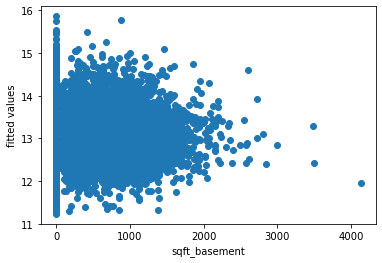

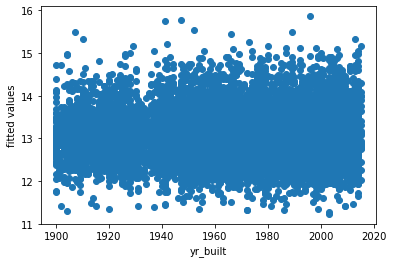

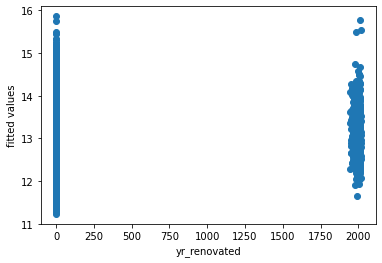

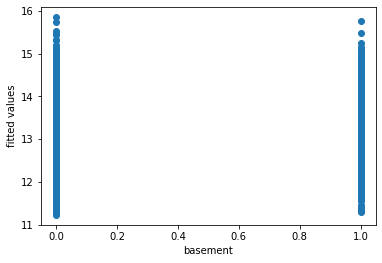

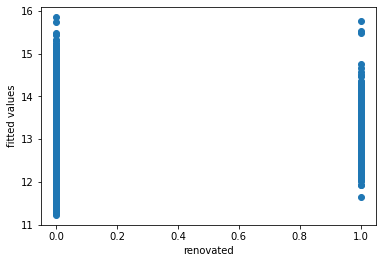

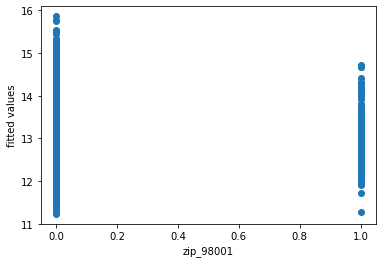

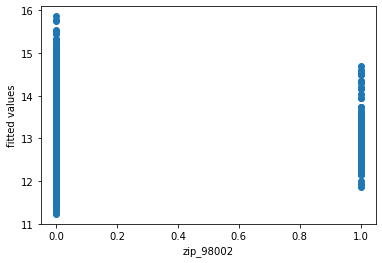

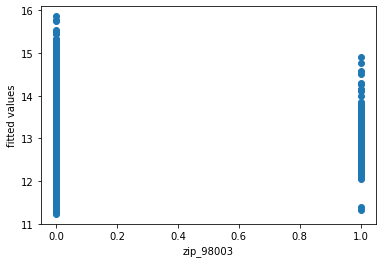

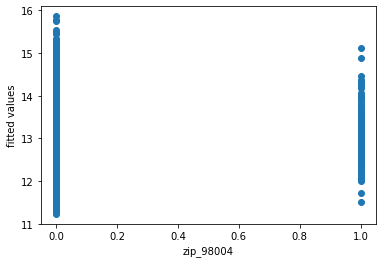

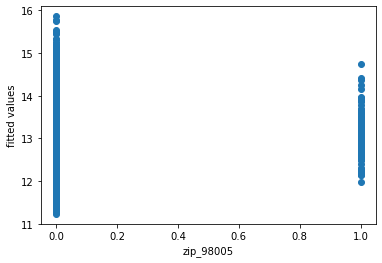

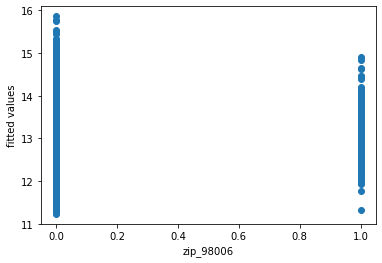

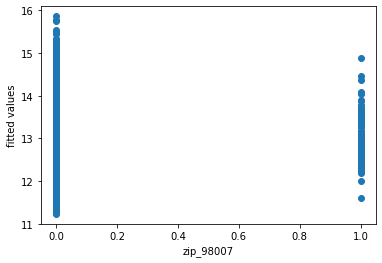

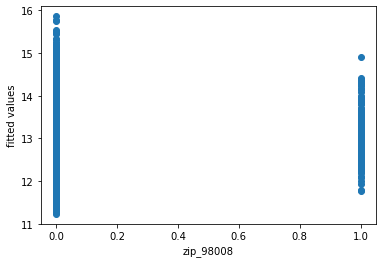

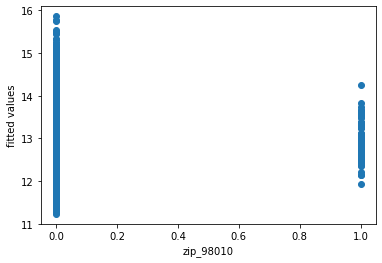

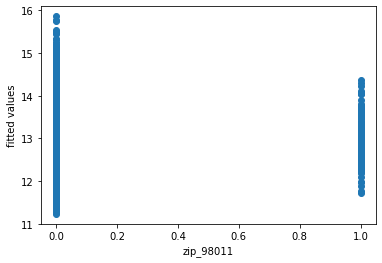

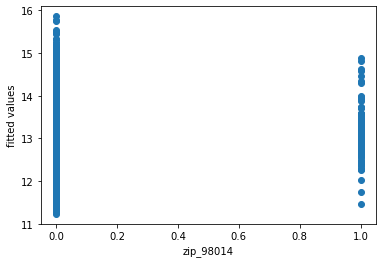

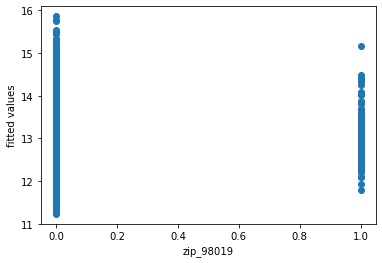

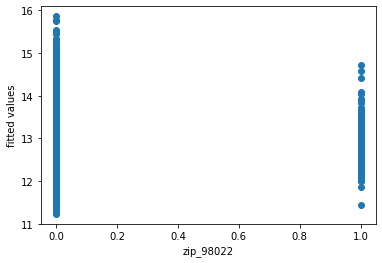

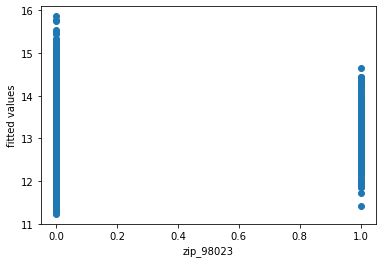

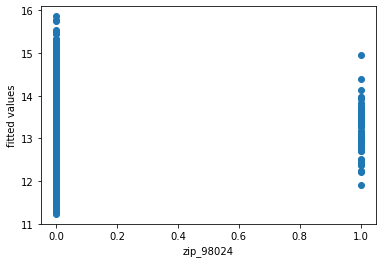

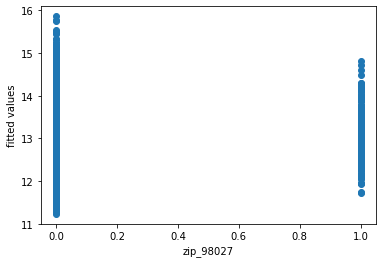

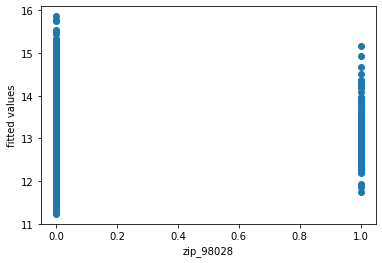

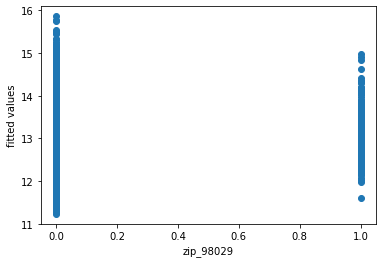

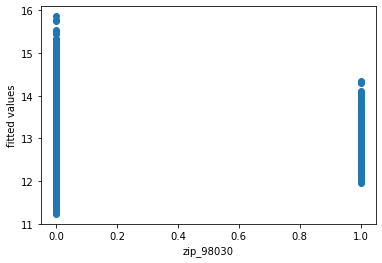

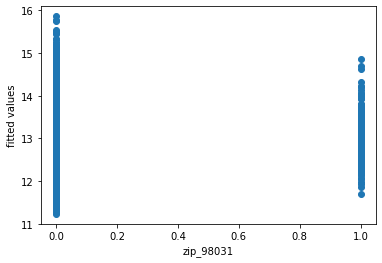

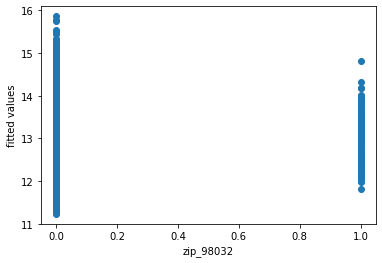

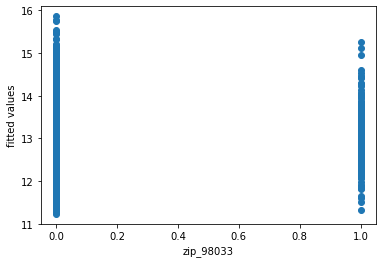

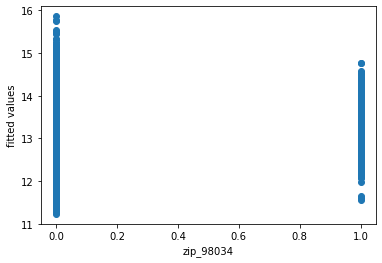

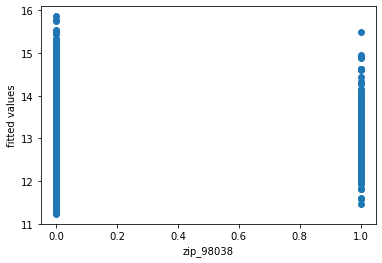

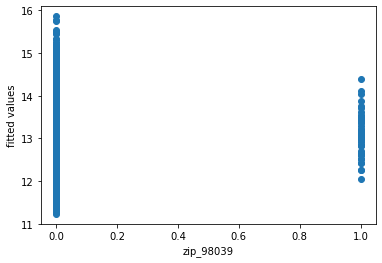

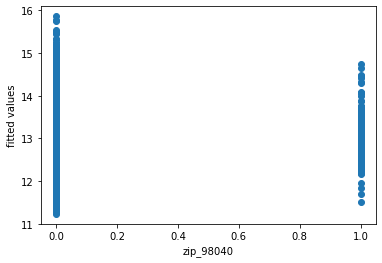

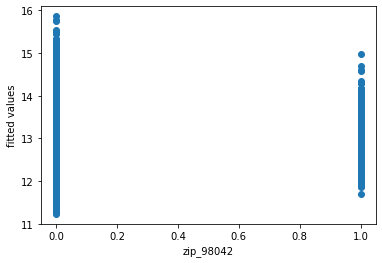

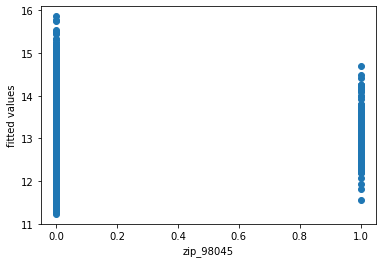

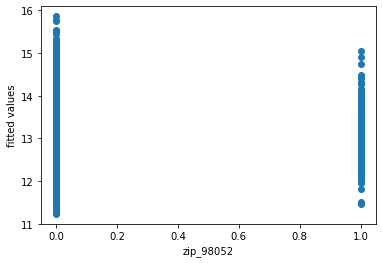

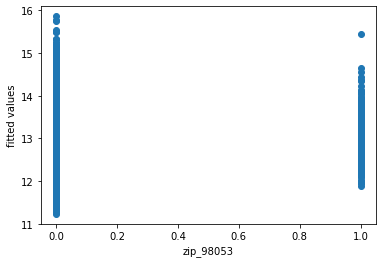

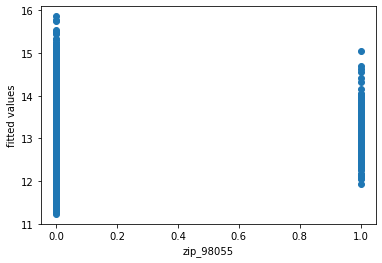

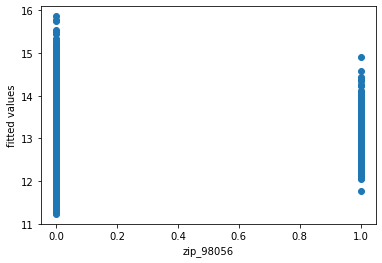

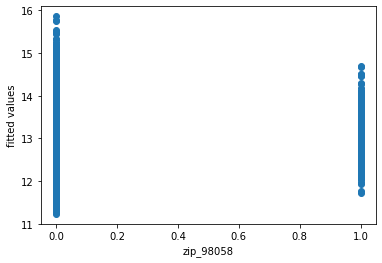

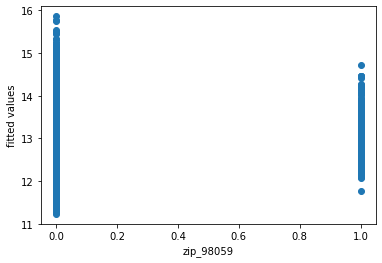

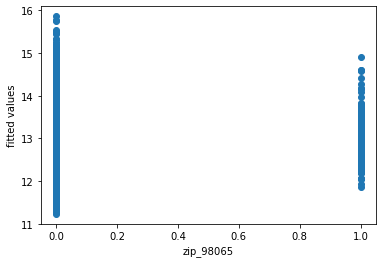

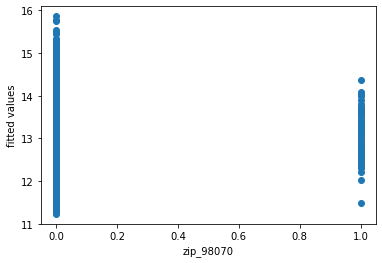

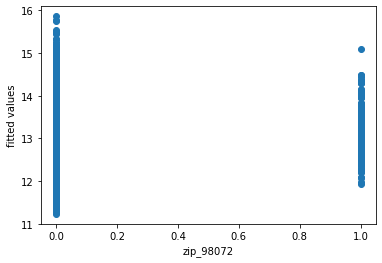

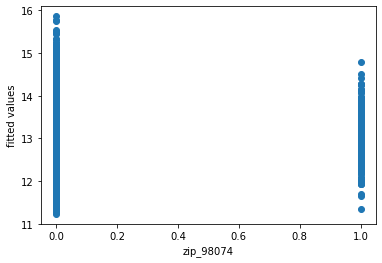

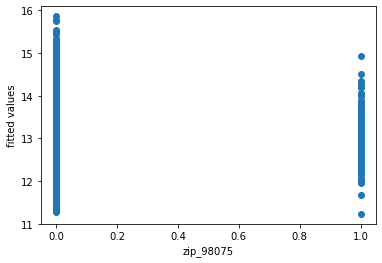

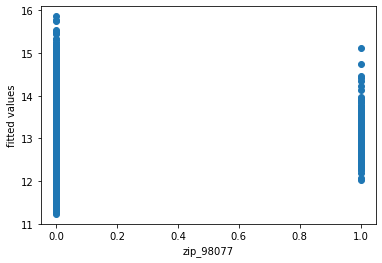

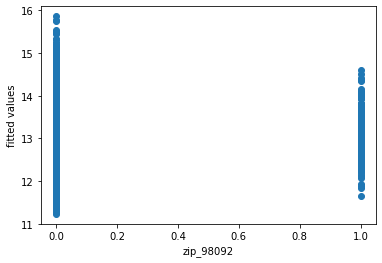

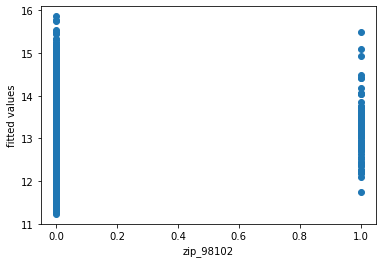

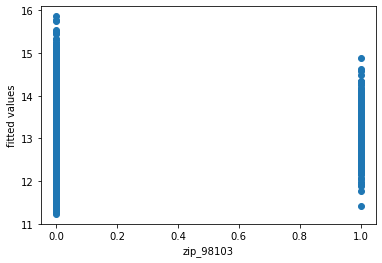

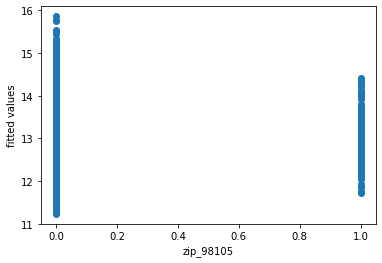

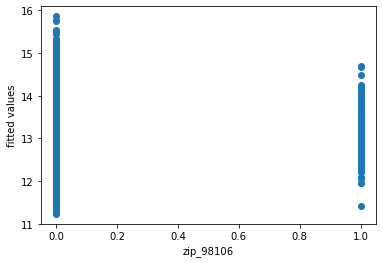

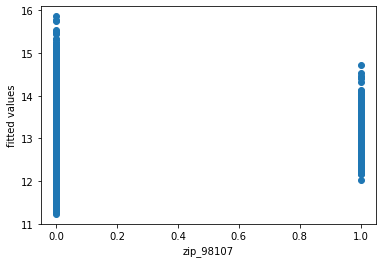

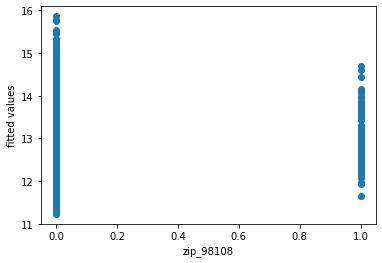

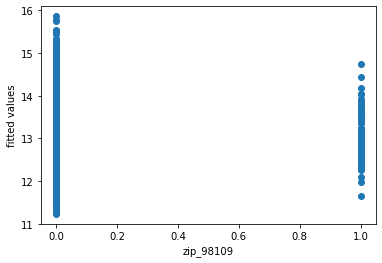

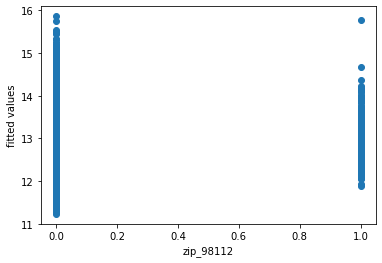

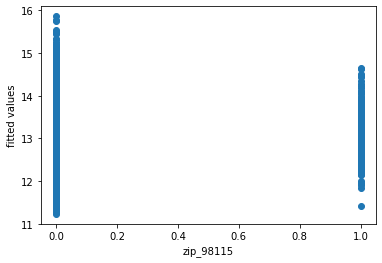

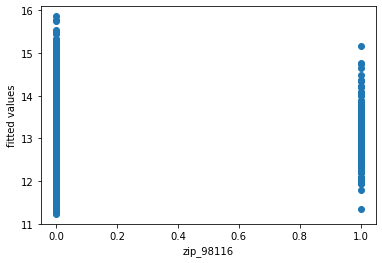

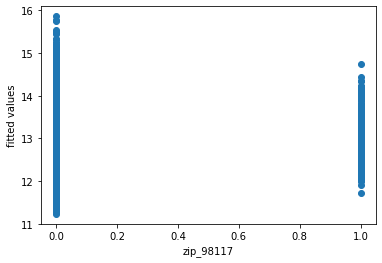

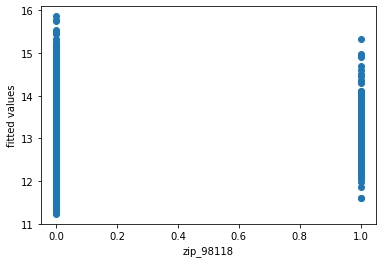

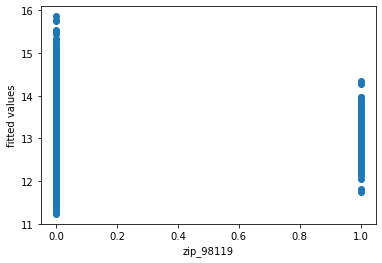

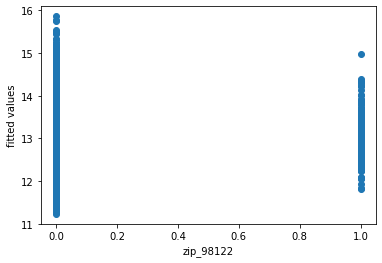

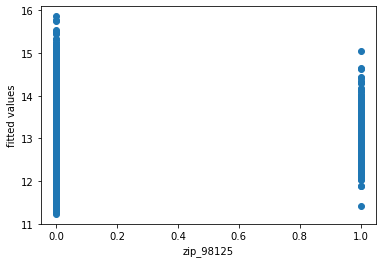

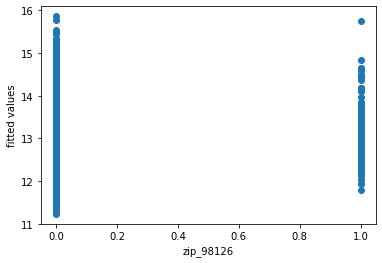

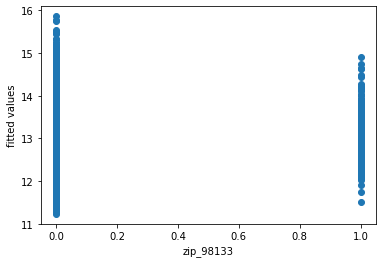

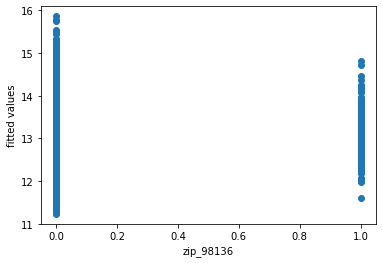

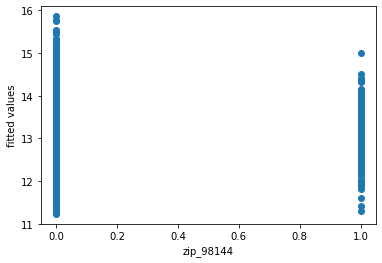

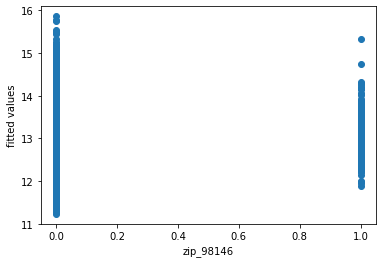

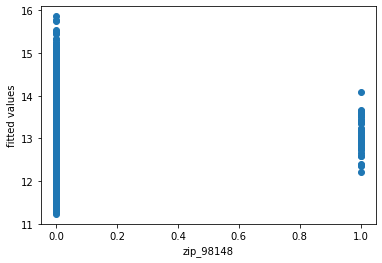

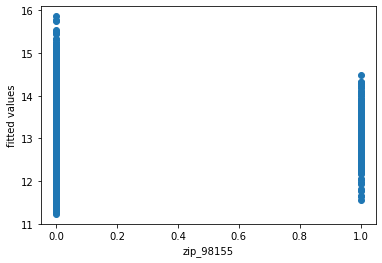

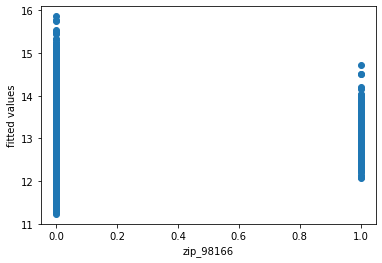

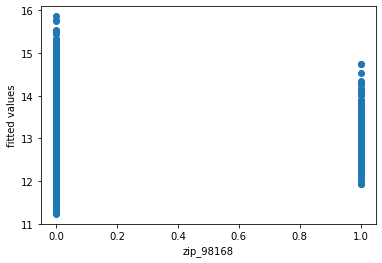

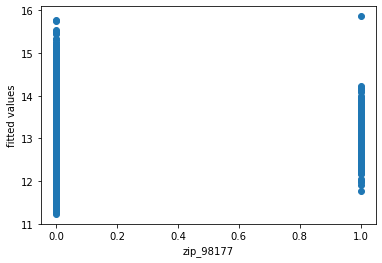

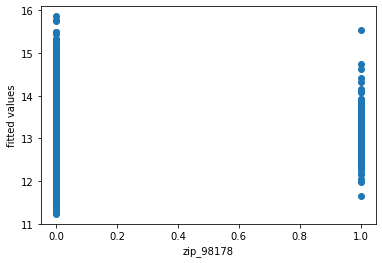

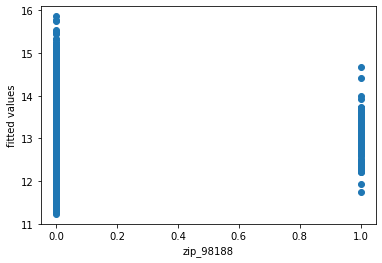

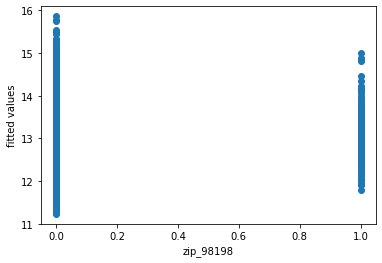

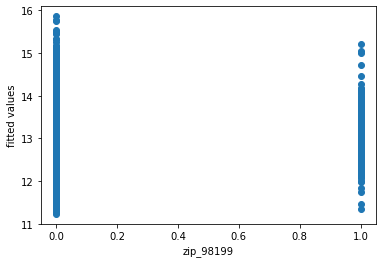

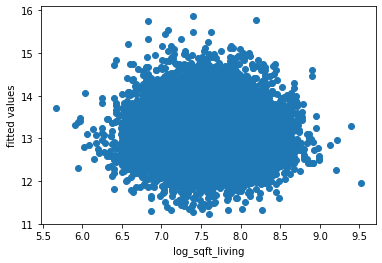

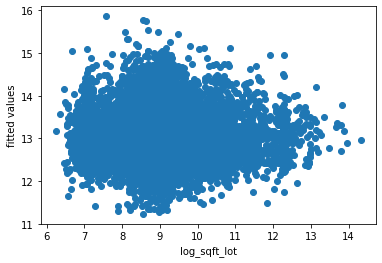

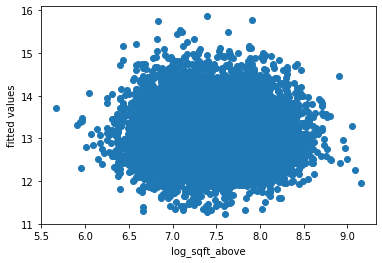

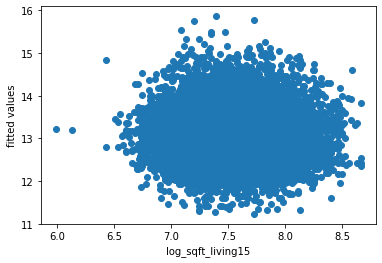

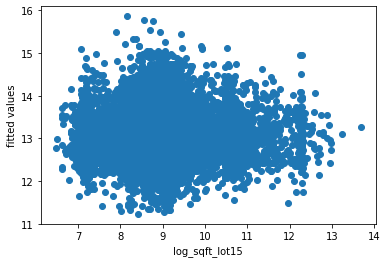

In [394]:
''' Transform non-linear X variables, or ones with non-constant variance '''
    
cols_to_log = ["sqft_living", "sqft_lot", "sqft_above", "sqft_living15",
               "sqft_lot15"]

for col in cols_to_log:
    log_predictor(X_train, col)
    log_predictor(X_test, col)

show_plots(X_train, y_train)

In [395]:
''' Assess model after correcting for non-constant variance and non-linearity '''

fit_model(X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     1551.
Date:                Sun, 09 Oct 2022   Prob (F-statistic):               0.00
Time:                        15:55:33   Log-Likelihood:                 5381.6
No. Observations:               17290   AIC:                        -1.059e+04
Df Residuals:                   17202   BIC:                            -9904.
Df Model:                          87                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -146.5886      8.73

In [396]:
''' Remove insignificant variables and assess model '''

X_train.drop(columns=["sqft_basement"], inplace=True)
X_test.drop(columns=["sqft_basement"], inplace=True)

fit_model(X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     1569.
Date:                Sun, 09 Oct 2022   Prob (F-statistic):               0.00
Time:                        15:55:38   Log-Likelihood:                 5381.5
No. Observations:               17290   AIC:                        -1.059e+04
Df Residuals:                   17203   BIC:                            -9914.
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -146.5825      8.73

In [397]:
''' Look for variables with high collinearity '''
    
calculate_vif(X_train, 5)

,variables,VIF
35,zip_98038,1.202434e+06
54,zip_98103,1.202330e+06
40,zip_98052,1.165091e+06
61,zip_98115,1.152662e+06
34,zip_98034,1.137783e+06
63,zip_98117,1.107927e+06
38,zip_98042,1.098084e+06
64,zip_98118,1.021049e+06
25,zip_98023,9.986834e+05
69,zip_98133,9.663839e+05


In [398]:
''' Check correlations for variables with high collinearity '''
X_p = X_train.loc[:, X_train.columns.isin(["yr_renovated", "renovated", "log_sqft_living", "log_sqft_lot",
                             "log_sqft_above", "log_sqft_lot15"])]

P = X_p.corr()

display(P)

,yr_renovated,renovated,log_sqft_living,log_sqft_lot,log_sqft_above,log_sqft_lot15
yr_renovated,1.000000,0.999970,0.050097,0.023883,0.027462,0.023858
renovated,0.999970,1.000000,0.049865,0.024103,0.027396,0.024043
log_sqft_living,0.050097,0.049865,1.000000,0.328620,0.865788,0.306240
log_sqft_lot,0.023883,0.024103,0.328620,1.000000,0.321421,0.918930
log_sqft_above,0.027462,0.027396,0.865788,0.321421,1.000000,0.301975
log_sqft_lot15,0.023858,0.024043,0.306240,0.918930,0.301975,1.000000


In [399]:
# Create interaction variables on collinear variables

create_interactions(X_train, "yr_renovated", "renovated")
create_interactions(X_test, "yr_renovated", "renovated")
create_interactions(X_train, "log_sqft_living", "log_sqft_above")
create_interactions(X_test, "log_sqft_living", "log_sqft_above")
create_interactions(X_train, "log_sqft_lot", "log_sqft_lot15")
create_interactions(X_test, "log_sqft_lot", "log_sqft_lot15")
create_interactions(X_train, "log_sqft_lot", "log_sqft_living")
create_interactions(X_test, "log_sqft_lot", "log_sqft_living")
create_interactions(X_train, "log_sqft_living", "log_sqft_lot15")
create_interactions(X_test, "log_sqft_living", "log_sqft_lot15")
create_interactions(X_train, "log_sqft_above", "log_sqft_lot")
create_interactions(X_test, "log_sqft_above", "log_sqft_lot")

fit_model(X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     1512.
Date:                Sun, 09 Oct 2022   Prob (F-statistic):               0.00
Time:                        15:56:00   Log-Likelihood:                 5533.5
No. Observations:               17290   AIC:                        -1.088e+04
Df Residuals:                   17198   BIC:                        -1.017e+04
Df Model:                          91                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [400]:
# Drop insignficant variables
X_train.drop(columns=["yr_built", "log_sqft_living:log_sqft_lot15", "log_sqft_above:log_sqft_lot", 
                "log_sqft_lot:log_sqft_lot15"], inplace=True)
X_test.drop(columns=["yr_built", "log_sqft_living:log_sqft_lot15", "log_sqft_above:log_sqft_lot", 
                "log_sqft_lot:log_sqft_lot15"], inplace=True)

fit_model(X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     1581.
Date:                Sun, 09 Oct 2022   Prob (F-statistic):               0.00
Time:                        15:56:12   Log-Likelihood:                 5531.4
No. Observations:               17290   AIC:                        -1.089e+04
Df Residuals:                   17202   BIC:                        -1.020e+04
Df Model:                          87                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

The number of influential observations in the Test dataset is 53.


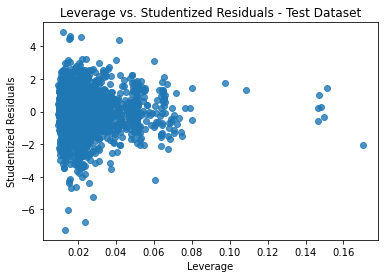

In [403]:
''' Identify and eliminate influential outliers '''

elim_infl_outliers("Training", X_train, y_train)
elim_infl_outliers("Test", X_test, y_test)

R-Squared of Predictions: 0.9037686573428276
Adjusted R-Squared of Predictions: 0.9017197124872084


Text(0, 0.5, 'Predictions')

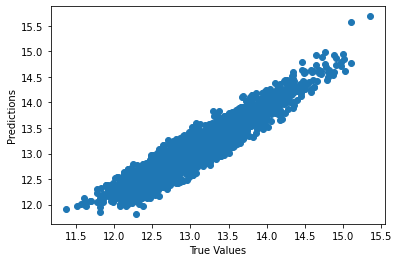

In [404]:
''' Assess Model Accuracy and Plot Predicted Values Against True Values In Test Set '''

lm = LinearRegression().fit(X_train, y_train)
y_hat = lm.predict(X_test)

r_squared = lm.score(X_test, y_test)
adj_r_squared = 1 - (1 - r_squared) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)
print("R-Squared of Predictions: " + str(r_squared))
print("Adjusted R-Squared of Predictions: " + str(adj_r_squared))
plt.scatter(y_test, y_hat)
plt.xlabel("True Values")
plt.ylabel("Predictions")

In [ ]:
''' To-Do '''
# 1. Add cross-validation to get the cross-predicted score
# 2. Look back at Duke homework code for additional ideas
# 3. Put custom functions in a separate Jupyter Notebook
# 4. Push to GitHub and add a readme document once you get access